# Data Engineering Capstone Project

## Project Summary
The goal of this project is to build an ETL pipeline to create a database storing I94 immigration data and related visa, temperature, demographics and airport information, which can be used to analyze and provide insight into the pattern of immigration.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

## Load libararies

In [124]:
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv

from src.utility import *
from src.data_model import *

# load environment variables
load_dotenv(find_dotenv())

True

## Load variables and Spark session

In [125]:
DATABASE_URL = os.getenv("DB_URL")

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
spark = create_spark_session()

## Scope the Project and Gather Data

### Scope
Plans: Build an ETL pipeline to implement data loading, preparation and database development.

Data: I94 Immigration Data, World Temperature Data, U.S. City Demographic Data, Airport Code Table

Solution: 
- Create a database containing a fact table and multiple dimension tables, which can be used by data analysts or business analysts to analyze immigrations in the U.S.
- A star schema is used for data model as there are only a small number of tables. If analysts want to pull the data from different tables, they can use the simple `JOIN`s for a fast query processing.

Tools: Python, Spark, SQLite, ER Diagram

### Describe and Gather Data 
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from.
- World Temperature Data: This dataset came from [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- U.S. City Demographic Data: This data comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- Airport Code Table: This is a simple table of airport codes and corresponding cities from [DataHub](https://datahub.io/core/airport-codes#data).


### Data loading

In [5]:
# load data from SAS file
# df_spark = spark.read.format('com.github.saurfang.sas.spark') \
#             .load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
# write to parquet
# df_spark.write.parquet("sas_data")

df_i94 = spark.read.parquet("./data/raw/sas_data")

In [6]:
df_airport = spark.read.csv("./data/raw/airport-codes_csv.csv", header=True, inferSchema=True)

In [7]:
df_demo = spark.read.csv("./data/raw/us-cities-demographics.csv", header=True, inferSchema=True, sep=';')

In [8]:
df_temp = spark.read.csv("./data/raw/GlobalLandTemperaturesByCity.csv", header=True, inferSchema=True)

## Explore and Assess the Data

### Explore Data

#### Dataframes Overview

In [9]:
def peek_df(df, show_num=5):
    """
    Retreive first five records by default to peek the spark dataframe
    """
    return df.limit(show_num).toPandas()

In [10]:
peek_df(df_i94).T

,0,1,2,3,4
cicid,5748517.0,5748518.0,5748519.0,5748520.0,5748521.0
i94yr,2016.0,2016.0,2016.0,2016.0,2016.0
i94mon,4.0,4.0,4.0,4.0,4.0
i94cit,245.0,245.0,245.0,245.0,245.0
i94res,438.0,438.0,438.0,438.0,438.0
i94port,LOS,LOS,LOS,LOS,LOS
arrdate,20574.0,20574.0,20574.0,20574.0,20574.0
i94mode,1.0,1.0,1.0,1.0,1.0
i94addr,CA,NV,WA,WA,WA
depdate,20582.0,20591.0,20582.0,20588.0,20588.0


Find redundancy

In [11]:
gr_visa = df_i94.groupby(['visatype', 'i94visa']).agg(count('cicid')).sort(desc("visatype"))
print("Check if there is any visatype that has more than one i94visa code: ")
gr_visa.groupby('visatype').agg(count('visatype')).alias("cnt").show()

Check if there is any visatype that has more than one i94visa code: 
+--------+---------------+
|visatype|count(visatype)|
+--------+---------------+
|      F2|              1|
|     GMB|              1|
|      B2|              1|
|      F1|              1|
|     CPL|              1|
|      I1|              1|
|      WB|              1|
|      M1|              1|
|      B1|              1|
|      WT|              1|
|      M2|              1|
|      CP|              1|
|     GMT|              1|
|      E1|              1|
|       I|              1|
|      E2|              1|
|     SBP|              1|
+--------+---------------+



In [12]:
df_i94.summary().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,25%,50%,75%,max
cicid,3096313,3078651.879075533,1763278.0997498818,6.0,1577768.0,3103193.0,4654073.0,6102785.0
i94yr,3096313,2016.0,0.0,2016.0,2016.0,2016.0,2016.0,2016.0
i94mon,3096313,4.0,3.522051388958887E-16,4.0,4.0,4.0,4.0,4.0
i94cit,3096313,304.9069344733559,210.02688853063336,101.0,135.0,213.0,512.0,999.0
i94res,3096313,303.28381949757664,208.583212927889,101.0,131.0,213.0,504.0,760.0
i94port,3096313,None,None,5KE,None,None,None,YSL
arrdate,3096313,20559.84854179794,8.77733947482668,20545.0,20552.0,20560.0,20567.0,20574.0
i94mode,3096074,1.0736897761487614,0.5158963131657286,1.0,1.0,1.0,1.0,9.0
i94addr,2943721,51.652482269503544,42.979062313709846,..,10.0,40.0,99.0,ZU
depdate,2953856,20573.95283554784,29.35696848162746,15176.0,20561.0,20570.0,20579.0,45427.0


In [13]:
peek_df(df_airport)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


In [14]:
df_airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [15]:
peek_df(df_demo)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.80,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.00,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.50,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.50,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.60,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [16]:
df_demo.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [17]:
peek_df(df_temp)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.07,1.74,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [18]:
df_temp.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



### Clean Data

#### Duplicates

In [19]:
def check_duplicates(df, listOfColumns=None):
    """
    Check duplicates by defined columns in the Spark dataframe
    """
    if not listOfColumns:
        listOfColumns = df_temp.columns
    if df.count() > df.dropDuplicates(listOfColumns).count():
        return False
    return True

In [20]:
df_i94 = df_i94.drop_duplicates(['cicid'])
df_airport = df_airport.drop_duplicates(['ident'])
df_demo = df_demo.drop_duplicates(['City', 'State', 'Race'])
df_temp = df_temp.drop_duplicates(['dt', 'City', 'Country'])

In [21]:
# Check duplicates
assert check_duplicates(df_i94, ['cicid'])
assert check_duplicates(df_airport, ['ident'])
assert check_duplicates(df_demo, ['City', 'State', 'Race'])
assert check_duplicates(df_temp, ['dt', 'City', 'Country'])

#### Missing values
Drop rows with 100% missing values.

In [22]:
df_i94 = df_i94.dropna(how='all')
df_airport = df_airport.dropna(how='all')
df_demo = df_demo.dropna(how='all')
df_temp = df_temp.dropna(how='all')

Drop columns with over 95% missing values.

In [23]:
def check_missing(df):
    """
    Check the percentage of missing values in the Spark dataframe. The result will be a Python plot.
    """
    result = df.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns])
    result.toPandas().T.rename(columns={0:'% missing'}).plot.bar()

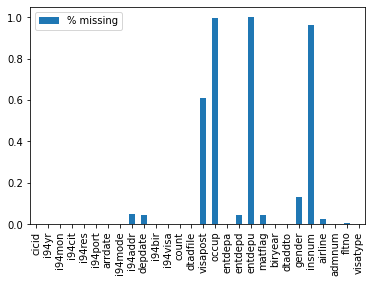

In [24]:
check_missing(df_i94)

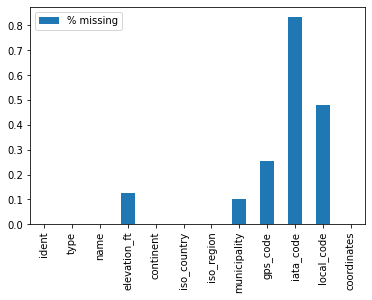

In [25]:
check_missing(df_airport)

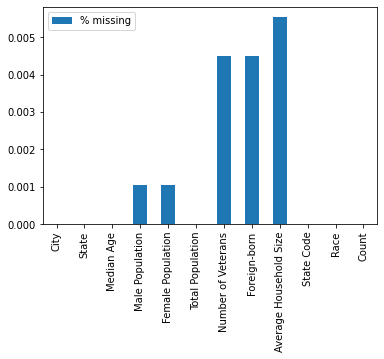

In [26]:
check_missing(df_demo)

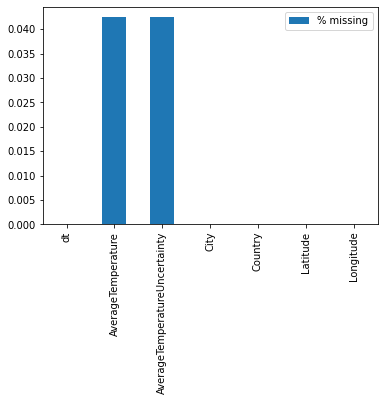

In [27]:
check_missing(df_temp)

In [28]:
df_i94 = df_i94.drop('occup', 'entdepu','insnum')

#### Other
Drop rows which have missing values in important data fields

In [30]:
df_temp = df_temp.dropna(subset=['AverageTemperature'])

Remove records with ports that are not included in SAS meta data

In [31]:
i94port_name_code_dict = build_i94_port_dict('./data/raw/i94port.txt')

In [32]:
i94port_codes = [code for name, code in i94port_name_code_dict.items()]

In [38]:
# clean i94 df
df_i94 = df_i94.filter(df_i94.i94port.isin(i94port_codes))

## Define the Data Model

### Conceptual Data Model

![conceptual_data_model](references/conceptual_data_model.png)

The fact table is I94_fact, which contains I94 related information for each record. This table is the main table that can be used for immigration analysis and can be connected to other tables for a futher insight.

Airport_dim includes data regarding airports, which can be used to analyze the impact of elevation or build geographic maps.

Visa_dim contains the visa types and their corresponding I94 Visa Codes.

Demographics_dim links to I94 fact table stemming from demograpihcs dataset. This table contains the population profiles by city in the U.S.

Temperature_dim provides the average temperature by city, which can be used to analyze the relatinoship between the temperature and I94 records.

### Mapping Out Data Pipelines

The ETL Pipeline
- Data Loading
- Data Processing
    - Drop duplicates
    - Drop missing values
    - Drop unrelated columns
    - Aggregate temperature table
- Database Development
    - Create tables
    - Import data into tables
- Data Validation

## Run Pipelines to Model the Data

### Create the data model

In [39]:
i94_fact = create_i94_fact(df_i94)

In [40]:
visa_dim = create_visa_dim(df_i94)

In [102]:
temperature_dim = create_temperature_dim(df_temp, i94port_name_code_dict)

In [103]:
airport_dim = create_airport_dim(df_airport, i94port_name_code_dict)

In [104]:
demo_dim = create_demographics_dim(df_demo, i94port_name_code_dict)

In [77]:
i94_fact.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,299,2016,4,103,103,NYC,2016-04-01,1,NY,2016-04-06,...,O,O,M,1962,6292016,None,OS,2147483647,00087,WT
1,305,2016,4,103,103,NYC,2016-04-01,1,NY,2016-04-11,...,O,O,M,1953,6292016,None,OS,2147483647,00087,WT
2,496,2016,4,103,103,CHI,2016-04-01,1,IL,2016-04-04,...,O,O,M,1952,6292016,None,OS,2147483647,00065,WB
3,558,2016,4,103,103,SFR,2016-04-01,1,CA,2016-04-03,...,G,O,M,1974,6292016,M,LH,2147483647,00454,WB
4,596,2016,4,103,103,NAS,2016-04-01,1,FL,2016-04-03,...,G,N,M,1992,6292016,M,UP,2147483647,00221,WT


In [69]:
visa_dim.limit(5).toPandas()

,visatype,i94visa
0,CP,2
1,CPL,2
2,GMB,1
3,SBP,2
4,B1,1


In [105]:
temperature_dim.limit(5).toPandas()

,city,country,average_temperature,i94port
0,Allentown,United States,9.52,None
1,Toulouse,France,10.48,None
2,Atyrau,Kazakhstan,8.07,None
3,Jhunjhunun,India,25.18,None
4,Puerto Plata,Dominican Republic,26.04,None


In [106]:
airport_dim.limit(5).toPandas()

,ident,type,name,elevation_ft,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,state,i94port
0,06IN,closed,Ellis Fly-In Airport,575,US,US-IN,Blackhawk,None,None,None,"-87.303596, 39.282799",IN,None
1,06VA,small_airport,Mount Horeb Field,1160,US,US-VA,Grottoes,06VA,None,06VA,"-78.85530090332031, 38.249000549316406",VA,None
2,0LA0,heliport,West Hackberry Heliport,10,US,US-LA,Hackberry,0LA0,None,0LA0,"-93.40019989013672, 30.008499145507812",LA,None
3,0MD6,small_airport,Walters Airport,750,US,US-MD,Mount Airy,0MD6,None,0MD6,"-77.10579681396484, 39.38119888305664",MD,None
4,0OH7,small_airport,Apple Airport,1000,US,US-OH,Piqua,0OH7,None,0OH7,"-84.1718978881836, 40.1432991027832",OH,None


In [107]:
demo_dim.limit(5).toPandas()

,id,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,Race,Count,i94port
0,0,Alafaya,Florida,33.50,39504,45760,85264,4176,15842,2.94,FL,White,63666,None
1,1,Baldwin Park,California,35.80,38747,38309,77056,780,34322,4.13,CA,Black or African-American,1560,None
2,2,Houston,Texas,32.60,1149686,1148942,2298628,71898,696210,2.66,TX,Asian,173854,HOU
3,3,Las Cruces,New Mexico,32.70,47835,53809,101644,9421,11888,2.58,NM,White,91201,LAS
4,4,Missouri City,Texas,37.20,34932,36846,71778,4274,18556,3.03,TX,Asian,17854,None


### Data Quality Checks

In [108]:
output_tables = {
    "i94_fact": i94_fact,
    "visa_dim": visa_dim,
    "temperature_dim": temperature_dim,
    "airport_dim": airport_dim,
    "demo_dim": demo_dim
}

In [109]:
def check_size(table_name):
    """Count checks on fact and dimension table.
    """
    cnt = output_tables[table_name].count()

    if cnt == 0:
        raise ValueError(f'Table {table_name} is empty.')
    print(f"Count check passed for {table_name}")
    return True

In [110]:
for name, table in output_tables.items():
    check_size(name)

Count check passed for i94_fact
Count check passed for visa_dim
Count check passed for temperature_dim
Count check passed for airport_dim
Count check passed for demo_dim


True

### Data dictionary

#### i94_fact
- record_id: Unique record ID
- i94yr: 4 digit year
- i94mon: Numeric month
- i94cit: 3 digit code of origin city
- i94res: 3 digit code for immigrant country of residence
- i94port: Port of admission
- arrdate: Arrival Date in the USA
- i94mode: Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
- i94addr: USA State of arrival
- depdate: Departure Date from the USA
- i94bir: Age of Respondent in Years
- count: Field used for summary statistics
- dtadfile: Character Date Field - Date added to I-94 Files
- visapost: Department of State where where Visa was issued
- entdepa: Arrival Flag - admitted or paroled into the U.S.
- entdepd: Departure Flag - Departed, lost I-94 or is deceased
- matflag: Match flag - Match of arrival and departure records
- biryear: 4 digit year of birth
- dtaddto: Character Date Field - Date to which admitted to U.S. (allowed to stay until)
- airline: Airline used to arrive in U.S.
- gender: Non-immigrant sex
- admnum: Admission Number
- fltno: Flight number of Airline used to arrive in U.S.
- visatype: Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

#### visa_dim
- visatype: Class of admission legally admitting the non-immigrant to temporarily stay in U.S.
- i94visa: Visa codes collapsed into three categories

#### temperature_dim
- average_temperature: Average temperature of city
- city: Name of city
- country: Name of country
- i94port: Port of admission

#### airport_dim
- ident: Unique Id
- type: Airport type
- name: Airport name
- elevation_ft: Elevation of airport
- iso_country: ISO code of country
- iso_region: ISO code of region
- municipality: Name of the area
- gps_code: Airport GPS code
- iata_code: Airport iata code
- local_code: Airport local code
- coordinates: coordinates of Airport
- i94port: Port of admission

#### demo_dim
- id: Unique Id
- city: City name
- state: State name
- median_age: Median age of the population
- male_population: Count of male population
- female_population: Count of female population
- total_population: Count of total population
- number_of_veterans: Count of total Veterans
- foreign_born: Count of residents of the city that were not born in the city
- average_household_size: Average city household size
- state_code: US state code
- race: Respondent race
- count: Count of city's individual per race
- i94port: Port of admission

### Create database

In [71]:
# create db
# conn = create_connection(DATABASE_URL)
# cur = conn.cursor()
# cur.execute("""
# CREATE TABLE visa_dim( 
#     visatype VARCHAR, 
#     i94visa INT,
#     PRIMARY KEY (visatype)
# );""")
# cur.close()

In [141]:
for name, table in output_tables.items():
    save_table_to_database(table, name, DATABASE_URL)

### Validate Tables in DB

In [143]:
for name, table in output_tables.items():
    check_db_table_size(name, DATABASE_URL)

Count check passed for i94_fact
Count check passed for visa_dim
Count check passed for temperature_dim
Count check passed for airport_dim
Count check passed for visa_dim


## Complete Project Write Up

* Clearly state the rationale for the choice of tools and technologies for the project.
    - Spark is used as it can glean data from different sources like SAS file, CSV file. Python is used since it is powerful for dev works in Jupyter notebook and ETL building. I choose SQLite as database because it is portable and easy to be shared. We can also easily configure it and replace the SQLite with other databases like PostgreSQL.

* Propose how often the data should be updated and why.
    - The data sould be updated on a monthly basis as the I94 immigration data is updated monthly.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     - The more people accessing the database the more CPU resources you need to get a fast experience. By using a distributed database you can improve your replications and partitioning to get faster query results for each user.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     - We can leverage data pipeline tools like Airflow to pull data and trigger the update as designed.
 * The database needed to be accessed by 100+ people.
     - We need to configure the database setting and replace the existing one with database service in the cloud like AWS Redshift.